In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import jaxttv, elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 6
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 6


In [2]:
import glob
npl = 6
datadir = "./toi1136/toi1136_fei_2/"

In [3]:
tcobs, errorobs, p_init = [], [], []
for i in range(npl):
    fname = glob.glob(datadir + "*_planet%d_ephemeris.txt"%(i))[0]
    tnum, tc, tcerr = np.array(pd.read_csv(fname, delim_whitespace=True)).T
    tcobs.append(tc)
    errorobs.append(tcerr)
    p, t0 = np.polyfit(tnum, tc, deg=1)
    p_init.append(p)
p_init = np.array(p_init)

In [4]:
import itertools
tclist = list(itertools.chain.from_iterable(tcobs))
print (p_init[0])
print (np.min(tclist), np.max(tclist))

4.171817635859455
1684.2802907079106 2650.0309951


In [5]:
dt = 0.1
t_start, t_end = 1680, 2655
jttv = jaxttv(t_start, t_end, dt)

# sympletic integrator is used.


In [6]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           1680.00
# first transit time in data:      1684.28
# last transit time in data:       2650.03
# integration ends at:             2655.00
# integration time step:           0.1000 (1/41 of innermost period)


initial objective function: 8985.58 (82 data)

running LM optimization...
objective function: 50.51 (82 data)
# elapsed time (least square): 40.2 sec


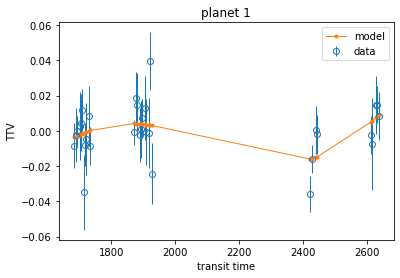

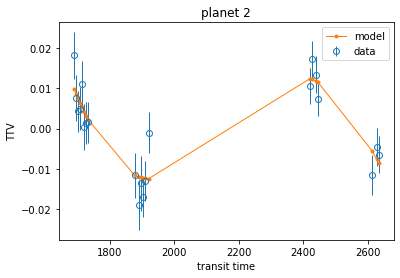

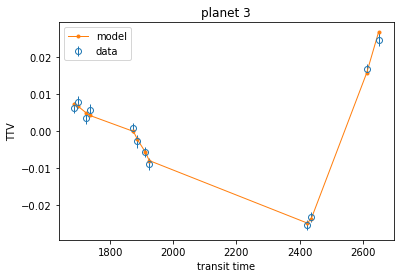

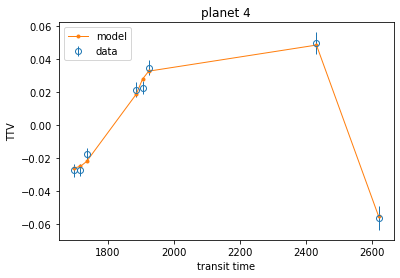

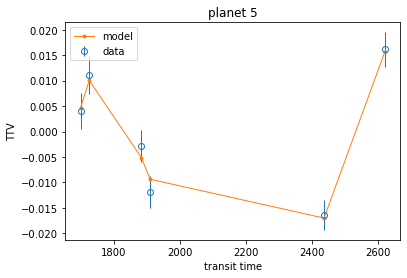

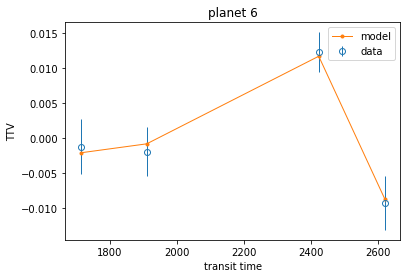

In [7]:
params_best = jttv.optim(amoeba=False, mmax=1e-4, emax=0.2)#, save=outdir+"ql")

In [10]:
tc = jttv.check_prec(params_best)

# fractional energy error (symplectic, dt=1.00e-01): 6.82e-10
# fractional energy error (Hermite, dt=4.17e-03): -1.15e-11
# max difference in tc: 1.07e-06 days (0.09 sec)


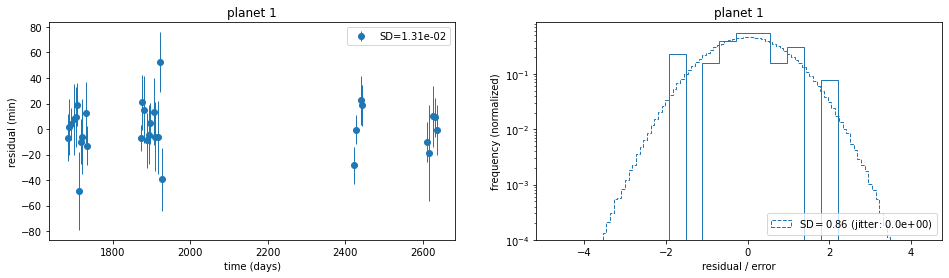

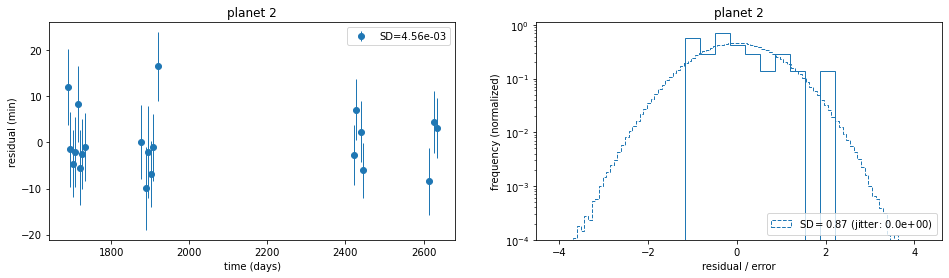

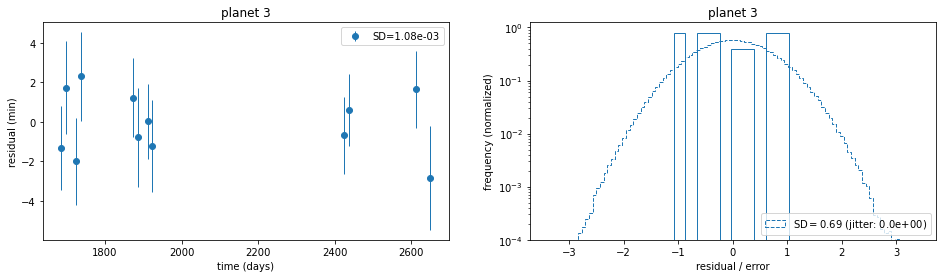

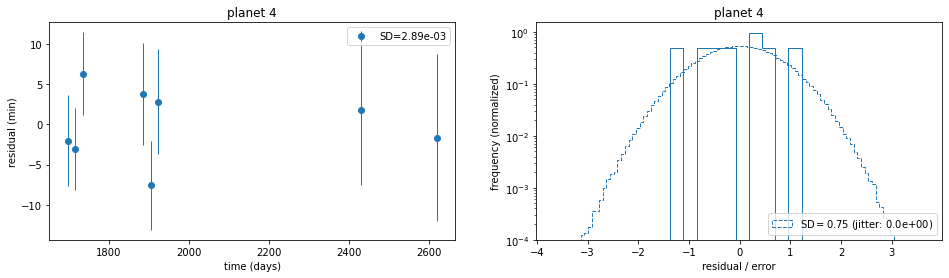

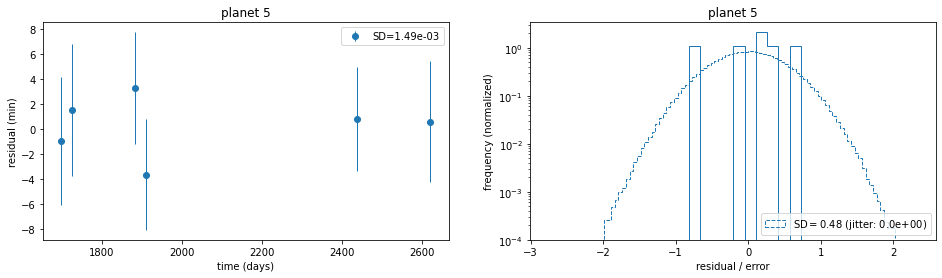

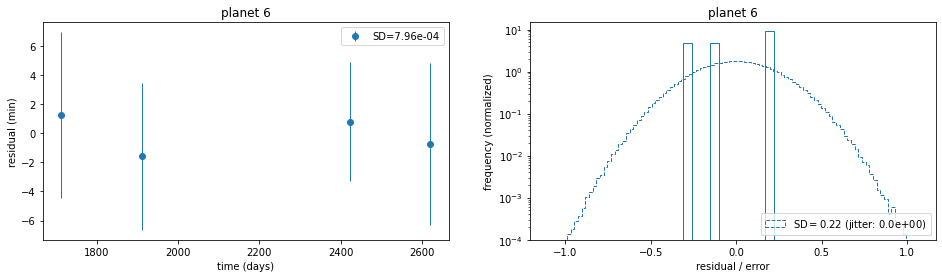

In [11]:
jttv.check_residuals(tc)

In [12]:
pdic = pd.DataFrame(elements_to_pdic(*params_to_elements(params_best, jttv.nplanet)))
print (pdic)

      pmass     period     ecosw     esinw  cosi  lnode          tic  \
0  1.558256   4.172190  0.128022  0.046560  -0.0    0.0  1684.284925   
1  1.614786   6.257434 -0.000114 -0.093865   0.0   -0.0  1688.715248   
2  3.326908  12.518442 -0.043765  0.094768  -0.0   -0.0  1686.067598   
3  2.789924  18.800790  0.010569 -0.062420  -0.0    0.0  1697.764958   
4  5.943094  26.318937  0.013696 -0.031632  -0.0    0.0  1699.390186   
5  8.164242  39.537485  0.012672 -0.137671  -0.0   -0.0  1711.934029   

        ecc     omega     lnmass      mass      cosw      sinw  
0  0.136226  0.348818 -12.272168  0.000005  0.939777  0.341788  
1  0.093865 -1.572011 -12.236533  0.000005 -0.001215 -0.999999  
2  0.104385  2.003431 -11.513693  0.000010 -0.419264  0.907864  
3  0.063308 -1.403061 -11.689721  0.000008  0.166950 -0.985965  
4  0.034470 -1.162182 -10.933506  0.000018  0.397338 -0.917672  
5  0.138253 -1.479009 -10.615972  0.000025  0.091658 -0.995791  


In [13]:
%timeit jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))

32.5 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random

tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(jttv.p_init)
ones = jnp.ones_like(p_guess)

pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), 
                             outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
init_strategy = init_to_value(values=pdic_init)

def model(dp=5e-1, dtic=1e-1, emax=0.5, mmin=1e-7, mmax=1e-3, uniform_mass=False, tcjitter=None):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))

    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = jnp.arctan2(sinw, cosw)
    numpyro.deterministic("omega", omega)

    lnode = ones * 0
    numpyro.deterministic("lnode", lnode)
    cosi = ones * 0
    numpyro.deterministic("cosi", cosi)
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = jnp.exp(lnmass)
        numpyro.deterministic("mass", mass)

    #elements = jnp.array([period, ecc*cosw, ecc*sinw, cosi, lnode, tic]).T
    elements = jnp.array([period, ecc*jnp.cos(omega), ecc*jnp.sin(omega), cosi, lnode, tic]).T
    numpyro.deterministic("elements", elements)

    tcmodel, ediff = jttv.get_ttvs(elements, jnp.hstack([1., mass]))
    if tcjitter is not None:
        lntcjitter = numpyro.sample("lntcjitter", dist.Uniform(low=-10, high=jnp.log(tcjitter)))
        tcjitter = numpyro.deterministic("tcjitter", jnp.exp(lntcjitter))
        tcerrmodel = jnp.sqrt(jttv.errorobs_flatten**2 + tcjitter**2)
    else:
        tcerrmodel = jttv.errorobs_flatten
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [15]:
pdic_init

{'period': DeviceArray([ 4.17219014,  6.25743391, 12.51844172, 18.80078996,
              26.31893715, 39.53748544], dtype=float64),
 'cosi': DeviceArray([-0.,  0., -0., -0., -0., -0.], dtype=float64),
 'lnode': DeviceArray([ 0., -0., -0.,  0.,  0., -0.], dtype=float64),
 'tic': DeviceArray([1684.28492475, 1688.71524848, 1686.0675981 , 1697.76495769,
              1699.39018596, 1711.9340293 ], dtype=float64),
 'ecc': DeviceArray([0.13622608, 0.09386514, 0.1043853 , 0.06330816, 0.03446964,
              0.13825318], dtype=float64),
 'lnmass': DeviceArray([-12.27216843, -12.23653321, -11.51369263, -11.68972132,
              -10.93350595, -10.61597199], dtype=float64),
 'mass': DeviceArray([4.68020602e-06, 4.84999344e-06, 9.99233134e-06,
              8.37950828e-06, 1.78500196e-05, 2.45212128e-05],            dtype=float64),
 'cosw': DeviceArray([ 0.93977725, -0.00121484, -0.41926435,  0.16694953,
               0.39733807,  0.09165842], dtype=float64),
 'sinw': DeviceArray([ 0.3417875

In [16]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)

In [17]:
nw, ns, linm, tcjitter = 100, 100, True, None # dt=0.1, 12hr
nw, ns, linm, tcjitter = 500, 500, True, None # x6, 116hr (A100)
#nw, ns, linm, tcjitter = 500, 1000, True, None # x4, 116hr (imac)

In [18]:
assert num_chains <= jax.local_device_count()
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns, num_chains=num_chains)

In [19]:
output = "toi1136/dt%.1f_"%jttv.dt
if not linm:
    output += "logm_"
if tcjitter is not None:
    output += "jit_"
output += "nw%d_ns%d_"%(nw, ns)
if num_chains > 1:
    output += "c%d_"%num_chains

In [20]:
output

'toi1136/dt0.1_nw500_ns500_c6_'

In [21]:
import os, dill
posterior = output + "mcmc.pkl"
if os.path.exists(posterior):
    print (posterior + " loaded.")
    mcmc = dill.load(open(posterior, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, mmin=0, mmax=5e-4, uniform_mass=linm, tcjitter=tcjitter)
    with open(output+"mcmc.pkl", "wb") as f:
        dill.dump(mcmc, f)

toi1136/dt0.1_nw500_ns500_c6_mcmc.pkl loaded.


In [22]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cosw[0]      0.61      0.80      0.64     -0.67      1.93     10.31      1.33
   cosw[1]     -0.09      0.71     -0.21     -1.05      1.21     20.23      1.29
   cosw[2]     -0.80      0.89     -0.76     -2.10      0.77     13.84      1.25
   cosw[3]      0.04      0.78      0.11     -1.33      1.21     10.17      1.48
   cosw[4]      0.26      0.86      0.27     -1.29      1.59     17.68      1.26
   cosw[5]      0.10      0.27      0.07     -0.16      0.49     39.80      1.18
    ecc[0]      0.08      0.05      0.09      0.00      0.14     16.66      1.36
    ecc[1]      0.10      0.07      0.11      0.00      0.19      7.84      1.71
    ecc[2]      0.06      0.05      0.05      0.00      0.13      6.20      1.65
    ecc[3]      0.05      0.03      0.05      0.00      0.09      9.43      1.48
    ecc[4]      0.03      0.02      0.02      0.00      0.06     34.24      1.24
    ecc[5]      0.11      0

In [23]:
samples = mcmc.get_samples()

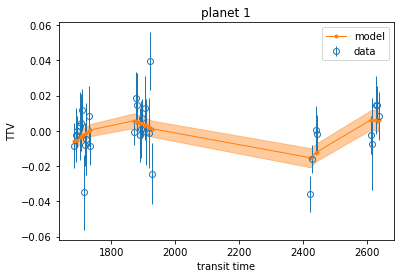

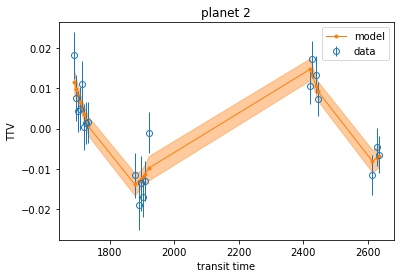

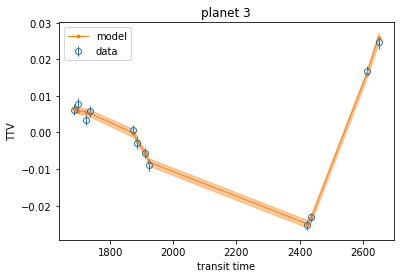

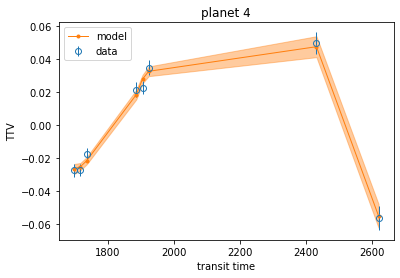

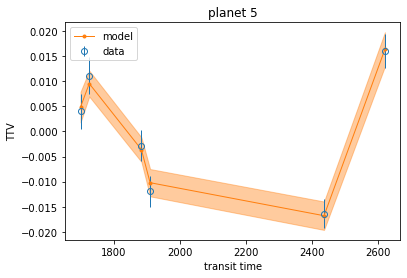

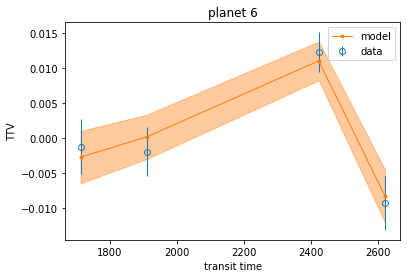

In [24]:
idx = samples['ediff']==samples['ediff']
mmodel, smodel = jnp.mean(samples['tcmodel'][idx], axis=0), jnp.std(samples['tcmodel'][idx], axis=0)
jttv.quicklook(mmodel, sigma=smodel, save=output+"postm")

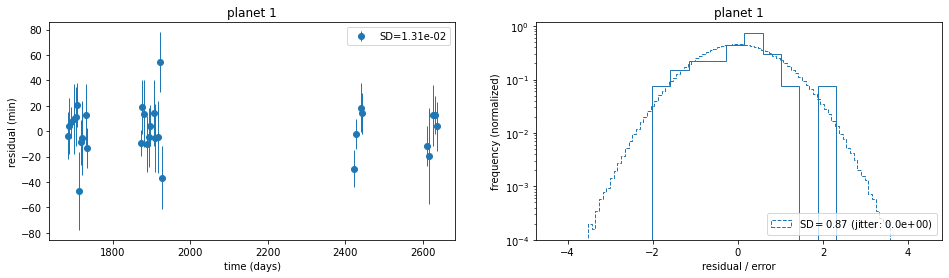

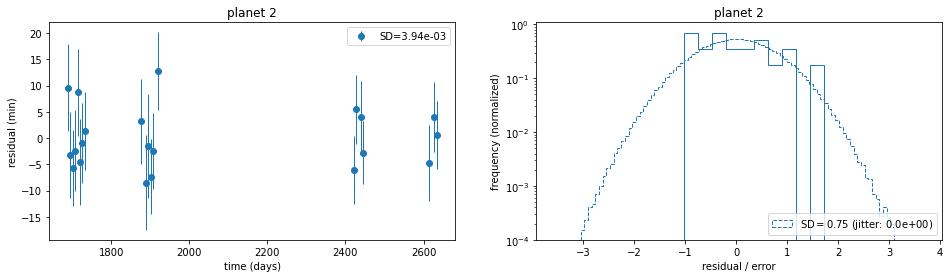

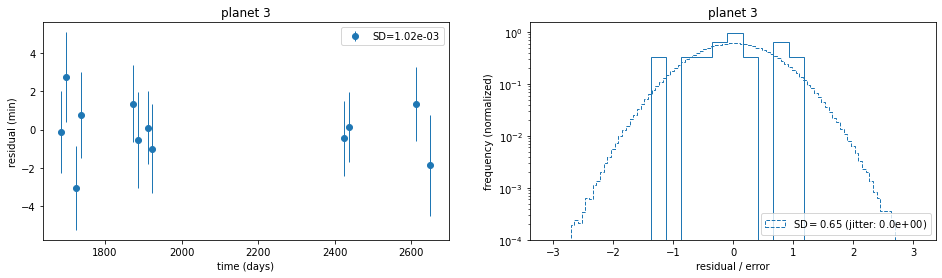

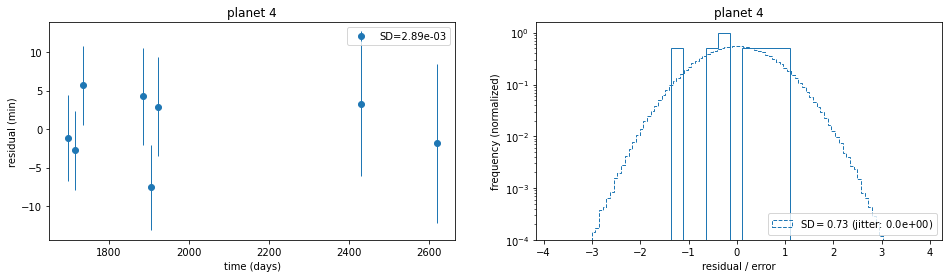

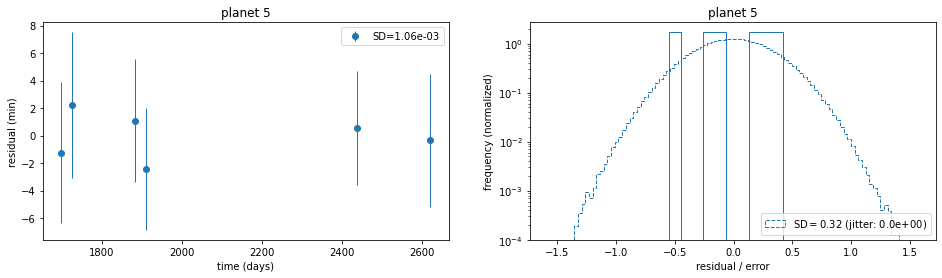

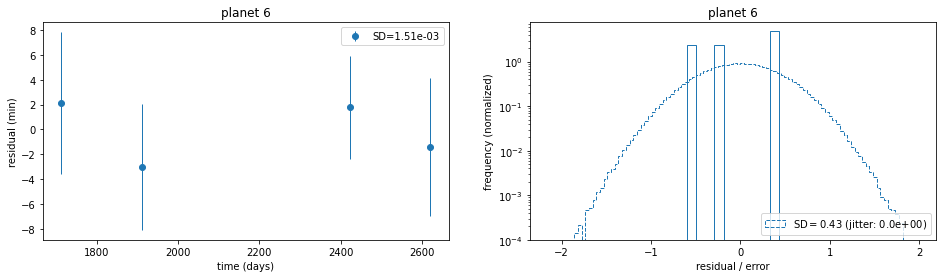

In [25]:
jttv.check_residuals(mmodel)

(array([   3.,    7.,   15.,   46.,  112.,  273.,  666., 1078.,  762.,
          38.]),
 array([-11.4297265 , -11.03619781, -10.64266913, -10.24914045,
         -9.85561176,  -9.46208308,  -9.06855439,  -8.67502571,
         -8.28149702,  -7.88796834,  -7.49443966]),
 <BarContainer object of 10 artists>)

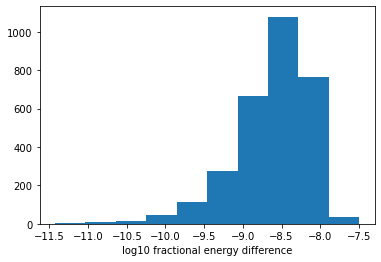

In [26]:
plt.xlabel("log10 fractional energy difference")
plt.hist(np.log10(np.abs(samples['ediff'])))

In [27]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']

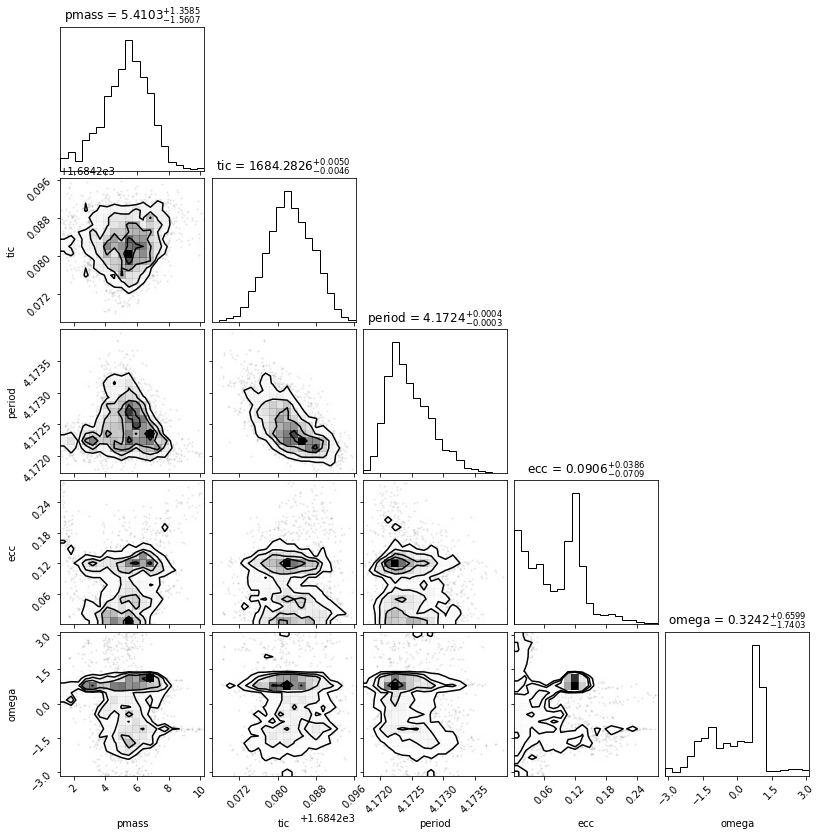

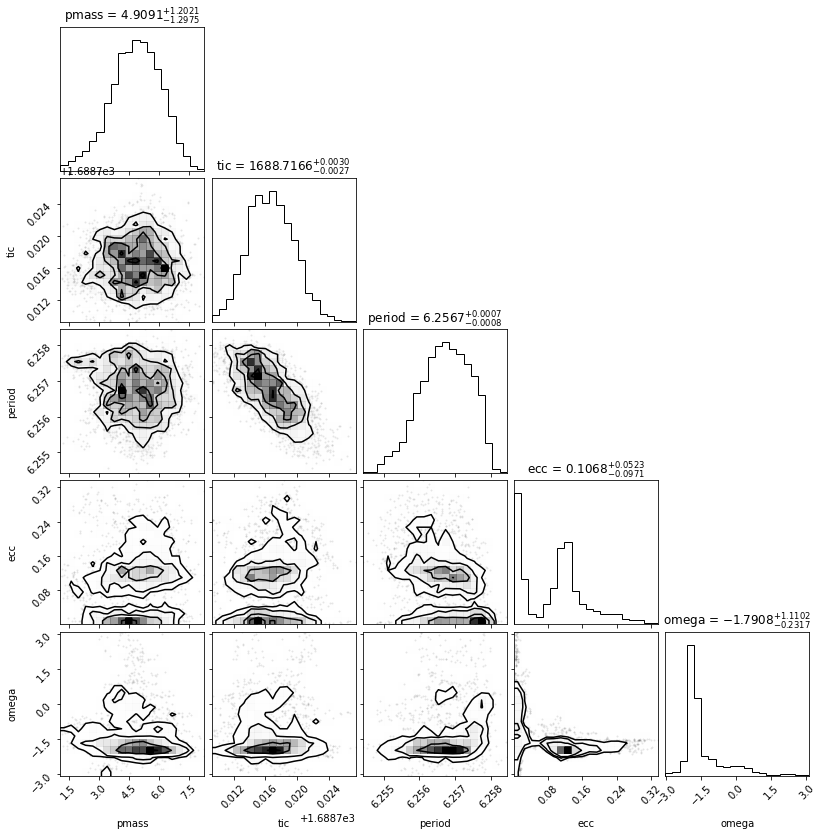

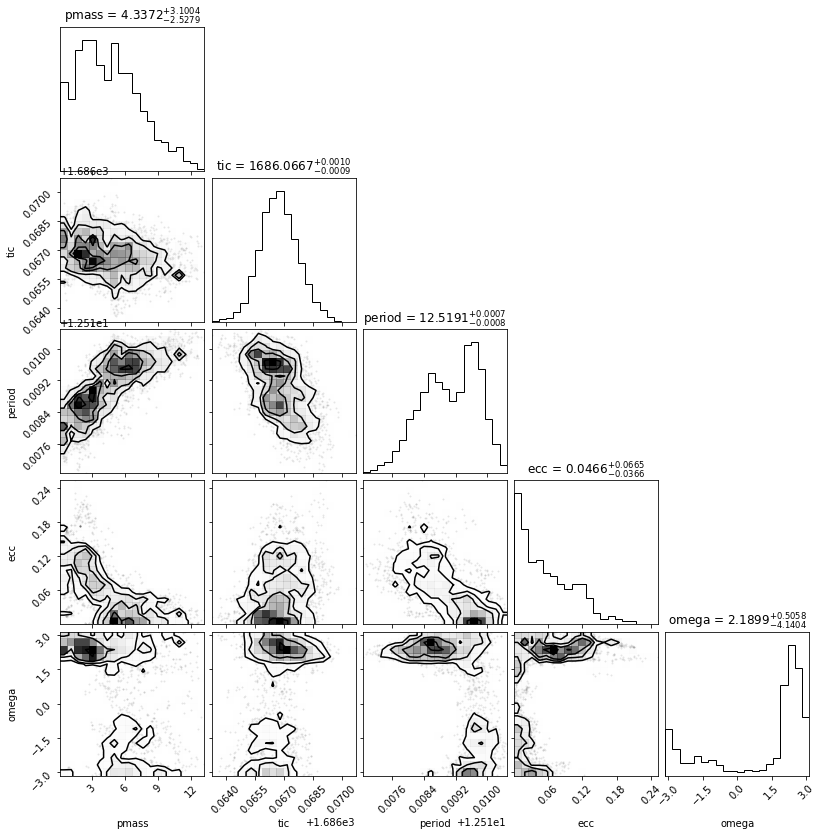

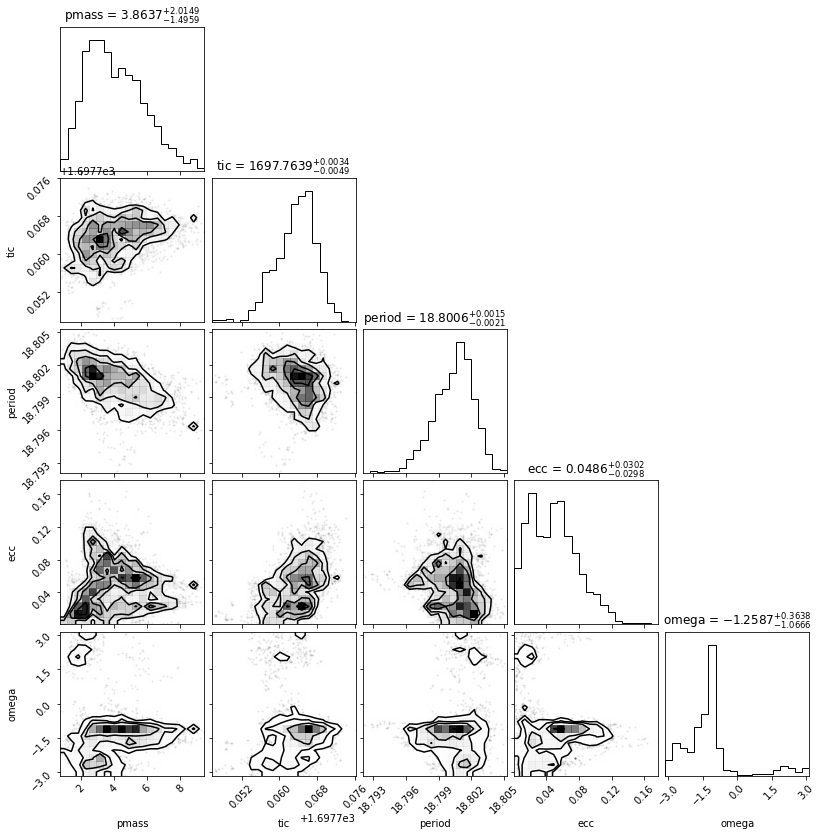

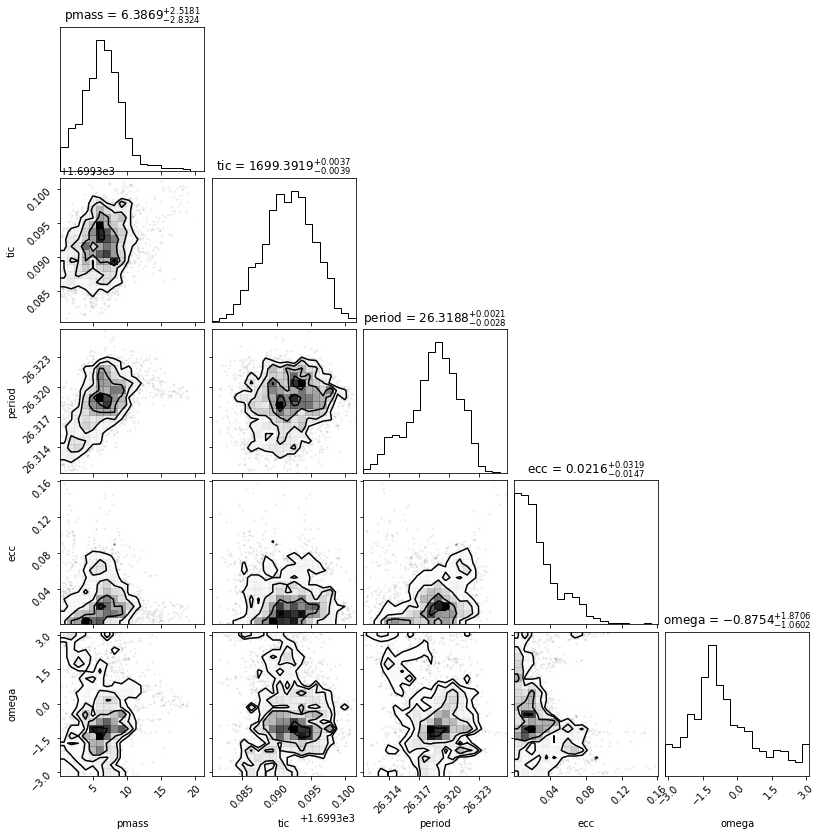

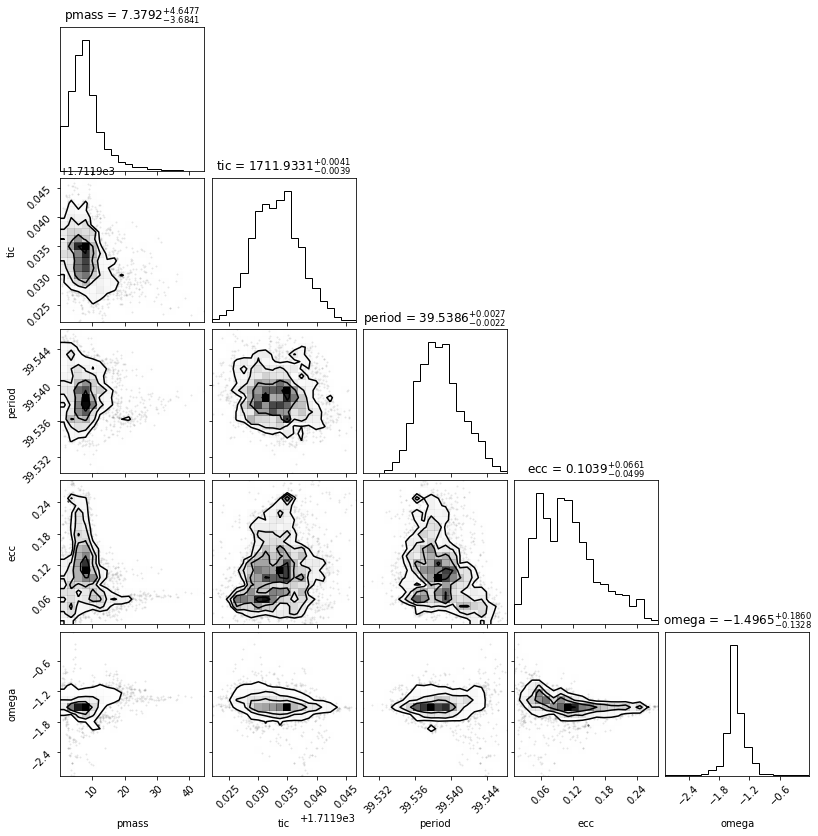

In [28]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    if tcjitter is not None:
        hyper['lntcjitter'] = samples['lntcjitter']
        labels = keys + ['lntcjitter']
    else:
        labels = keys
    fig = corner.corner(hyper, labels=labels, show_titles=True, title_fmt=".4f")
    plt.savefig(output+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight");

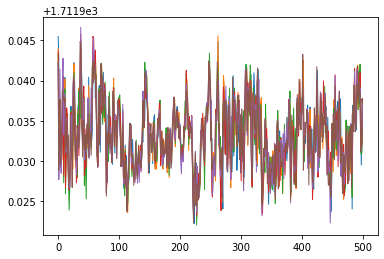

In [36]:
plt.plot(samples[k][:,j].reshape(-1,6), lw=1)

/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


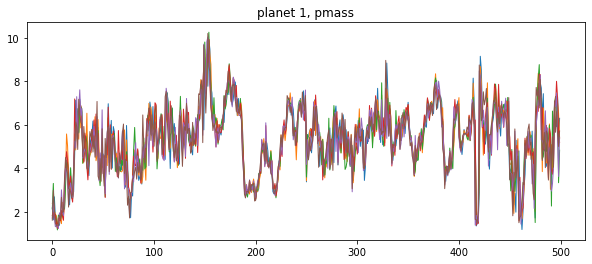

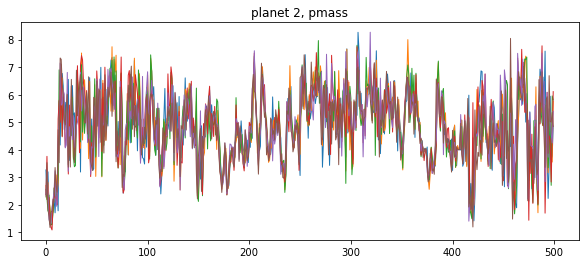

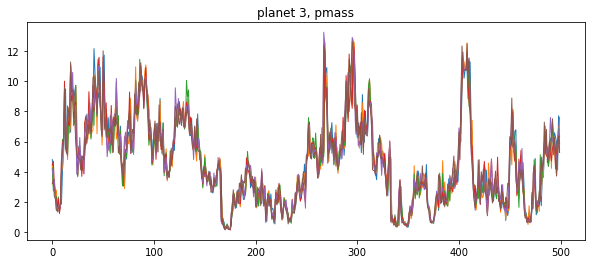

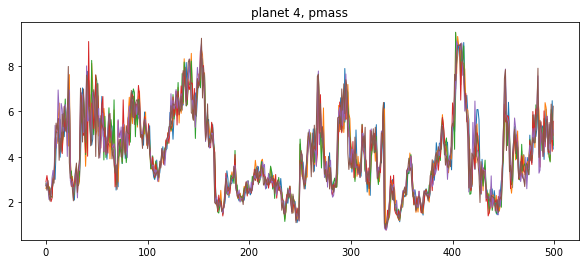

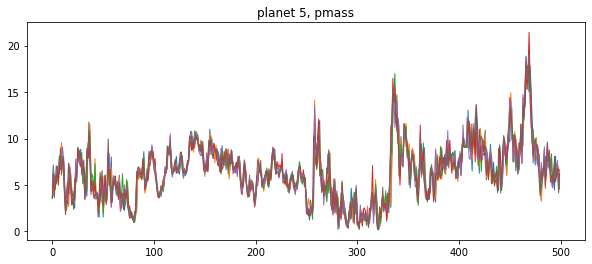

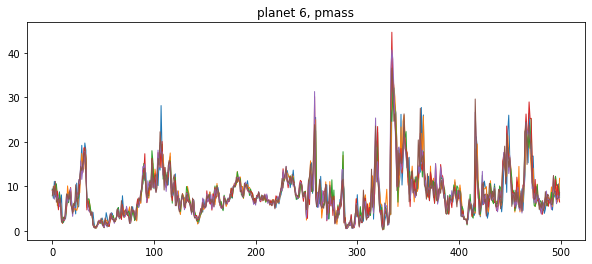

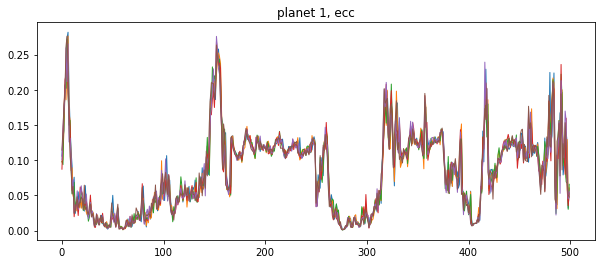

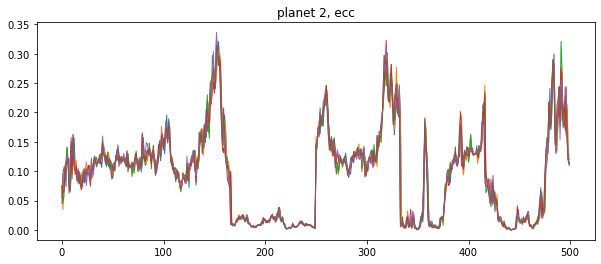

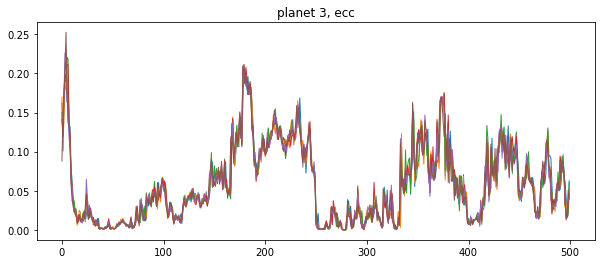

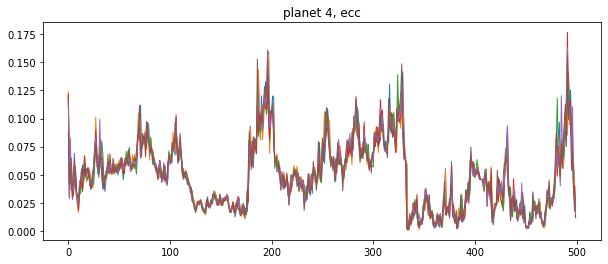

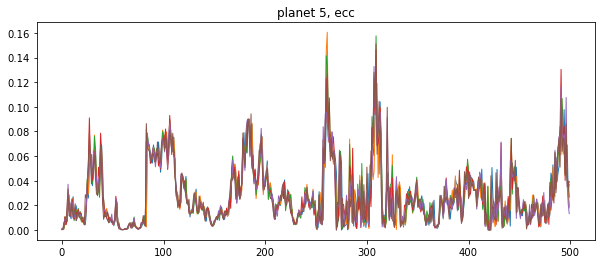

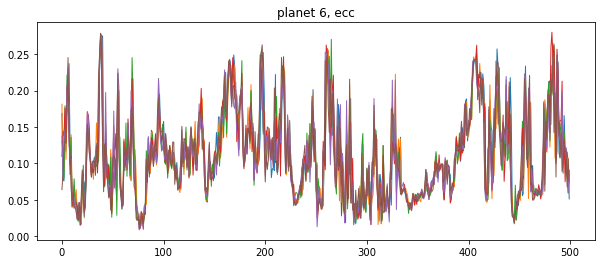

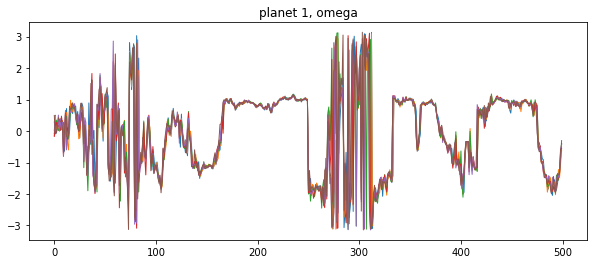

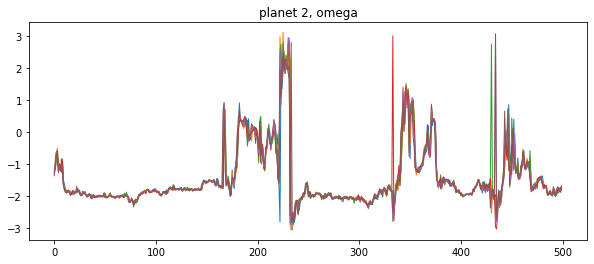

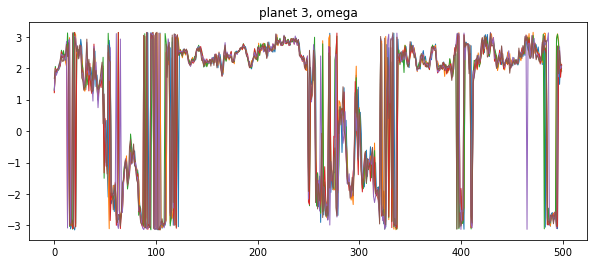

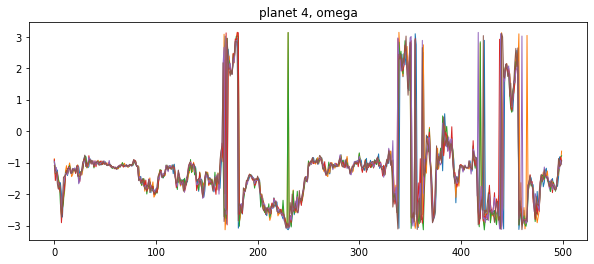

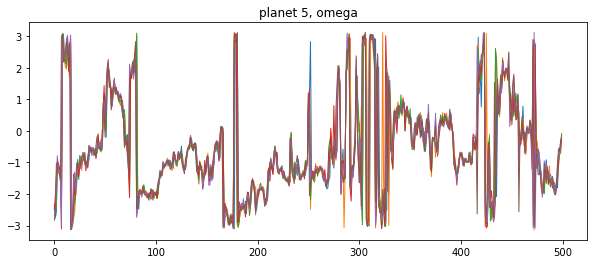

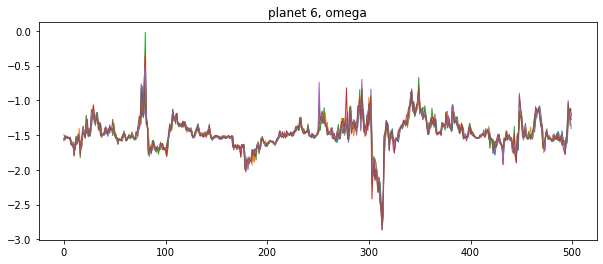

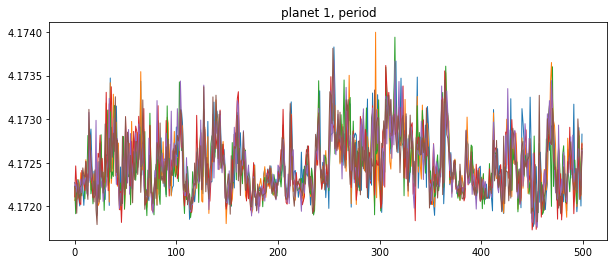

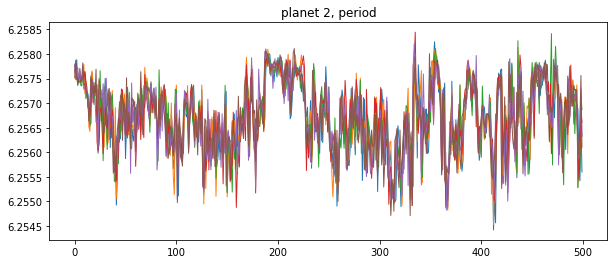

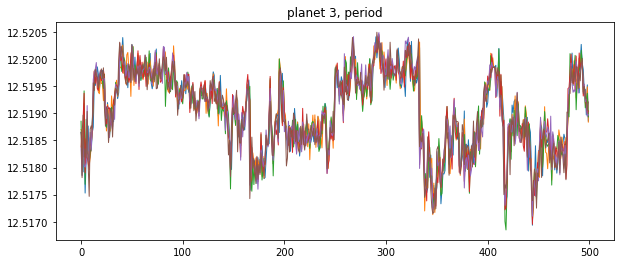

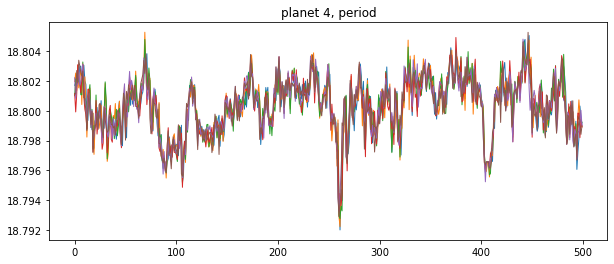

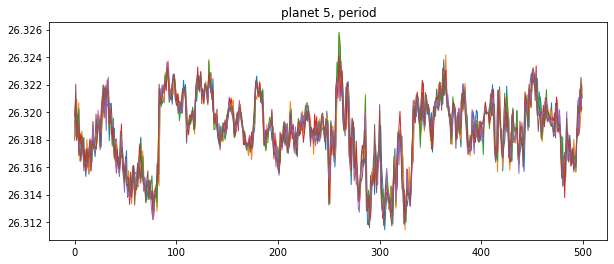

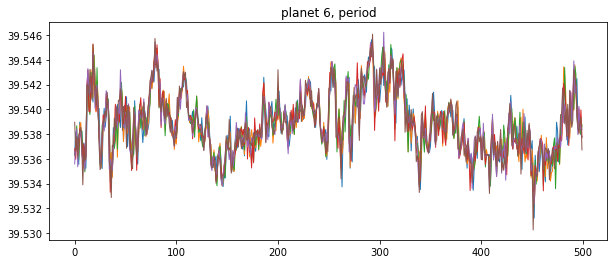

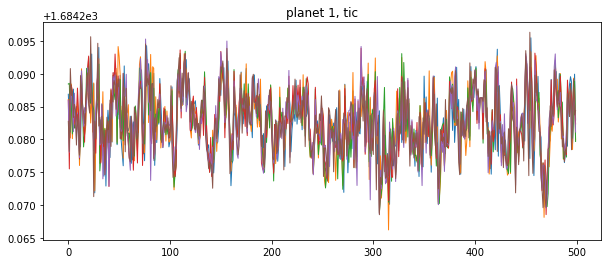

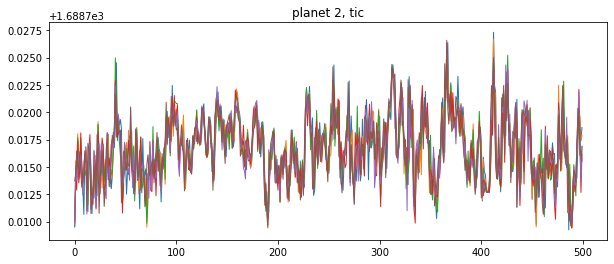

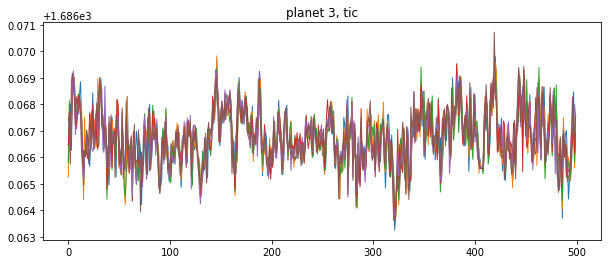

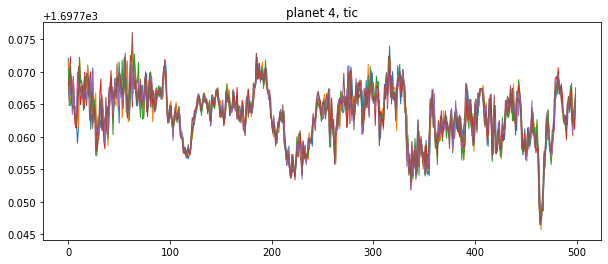

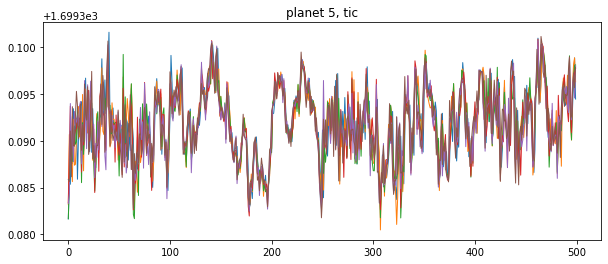

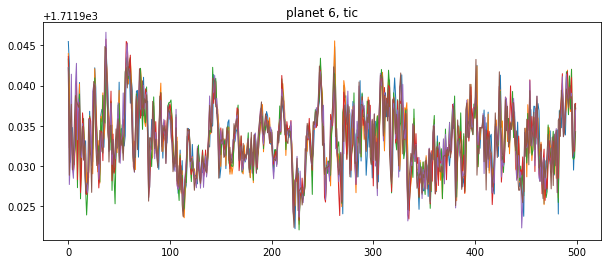

In [37]:
keys = ['pmass', 'ecc', 'omega', 'period', 'tic']
for k in keys:
    for j in range(npl):
        plt.figure(figsize=(10,4))
        plt.title("planet %d, %s"%((j+1), k))
        #plt.plot(samples[k][:,j], lw=1)
        plt.plot(samples[k][:,j].reshape(-1,6), lw=1)

### check convergence of transit times

In [38]:
jttv2 = jaxttv(t_start, t_end, dt / 10.)
jttv2.set_tcobs(tcobs, p_init, errorobs=errorobs)

# sympletic integrator is used.
# integration starts at:           1680.00
# first transit time in data:      1684.28
# last transit time in data:       2650.03
# integration ends at:             2655.00
# integration time step:           0.0100 (1/417 of innermost period)


In [ ]:
k = 50
tc1, ediff1 = jttv2.get_ttvs(samples['elements'][k], jnp.hstack([1., samples['mass'][k]]))
plt.xlabel("tc difference (sec)")
plt.hist(np.array(samples['tcmodel'][k] - tc1)*86400.)